# Processed Data Visualization Notebook

In [127]:
%matplotlib inline
import h5py
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

## Open Processed Simulation Output

In [128]:
h5f = h5py.File("../data/processed/proc_sims_v5.h5", "r")

## Data Structure

In [129]:
print("Top-Level:\n", list(h5f.keys()))
print("Header:\n", list(h5f["sims"]))
print("Header (sim<n>):\n", list(h5f["sims"]["sim0"]))

Top-Level:
 ['sims']
Header:
 ['sim0', 'sim1', 'sim10', 'sim11', 'sim12', 'sim13', 'sim14', 'sim15', 'sim16', 'sim17', 'sim18', 'sim19', 'sim2', 'sim20', 'sim21', 'sim22', 'sim23', 'sim24', 'sim25', 'sim26', 'sim27', 'sim28', 'sim29', 'sim3', 'sim30', 'sim31', 'sim32', 'sim33', 'sim34', 'sim35', 'sim36', 'sim37', 'sim38', 'sim39', 'sim4', 'sim40', 'sim41', 'sim42', 'sim43', 'sim44', 'sim45', 'sim46', 'sim47', 'sim48', 'sim49', 'sim5', 'sim50', 'sim51', 'sim52', 'sim53', 'sim54', 'sim55', 'sim56', 'sim57', 'sim58', 'sim59', 'sim6', 'sim60', 'sim61', 'sim62', 'sim63', 'sim64', 'sim65', 'sim66', 'sim67', 'sim68', 'sim69', 'sim7', 'sim70', 'sim71', 'sim72', 'sim73', 'sim74', 'sim75', 'sim76', 'sim77', 'sim78', 'sim79', 'sim8', 'sim80', 'sim81', 'sim82', 'sim83', 'sim84', 'sim85', 'sim86', 'sim87', 'sim88', 'sim89', 'sim9', 'sim90', 'sim91', 'sim92', 'sim93', 'sim94', 'sim95', 'sim96', 'sim97', 'sim98', 'sim99']
Header (sim<n>):
 ['alpha_zre', 'b0_zre', 'kb_zre', 'ksz_map', 'pk_tt', 'tau', 

## Build DataFrame

In [130]:
rows = []
sims = h5f["sims"]

# Iterate through all sims in sims/
for name in sorted(sims.keys(), key=lambda s: int(s[3:]) if s.startswith("sim") and s[3:].isdigit() else s):
    g = sims[name]
    rows.append({
        "sim":          name,
        # Parameters
        "alpha_zre":    float(g["alpha_zre"][()]),
        "kb_zre":       float(g["kb_zre"][()]),
        "zmean_zre":    float(g["zmean_zre"][()]),
        "b0_zre":       float(g["b0_zre"][()]),
        "tau":          float(g["tau"][()]),
        # Info about per-sim grids
        "n_z":          int(g["zval_list"].shape[0]),
        "n_xm":         int(g["xmval_list"].shape[0]),
    })

df = pd.DataFrame(rows)
df.head()

,sim,alpha_zre,kb_zre,zmean_zre,b0_zre,tau,n_z,n_xm
0,sim0,0.123569,0.361813,8.026353,0.59312,0.061644,26,26
1,sim1,0.658593,1.319570,8.276313,0.59312,0.063535,26,26
2,sim2,0.569787,0.369425,8.481533,0.59312,0.064694,26,26
3,sim3,0.151896,1.349346,8.802202,0.59312,0.069647,26,26
4,sim4,0.194290,1.111912,7.723515,0.59312,0.058893,26,26


## Simulation Parameters
- **`alpha`** (0.10 - 0.90) : Controls how long reionization lasts.
- **`kb`** (0.10 - 2.0) : Determines how uneven the ionized regions are (higher values more clustered).
- **`zmean`** (7.0 - 9.0) : Sets the midpoint of reionization.
- **`b0`** (? - ?) : Adjusts the overall strength or amplitude of the ionization field.

### Summary

In [131]:
def summarize(col):
    s = df[col]
    return {"min": s.min(), "max": s.max(), "mean": s.mean(), "std": s.std(ddof=1), "n_unique": s.nunique()}

summary = pd.DataFrame({c: summarize(c) for c in ["alpha_zre","kb_zre","zmean_zre", "b0_zre"]}).T
summary


,min,max,mean,std,n_unique
alpha_zre,0.106138,0.892581,0.500387,2.320735e-01,100.0
kb_zre,0.104399,1.987047,1.050257,5.515132e-01,100.0
zmean_zre,7.013623,8.984811,7.999837,5.803226e-01,100.0
b0_zre,0.593120,0.593120,0.593120,2.231632e-16,1.0


### Histogram of Parameter Space
- Histograms should be flat for uniform coverage.

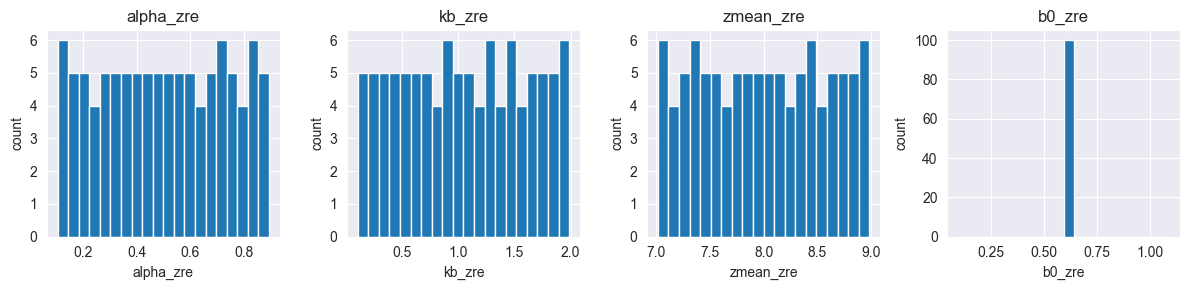

In [132]:
plt.figure(figsize=(12,3))
for i, col in enumerate(["alpha_zre","kb_zre","zmean_zre", "b0_zre"], 1):
    plt.subplot(1,4,i)
    plt.hist(df[col], bins=20)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.show()


### Spearman Correlation (Independence)
- Measure how monotonic the relationship is between pairs or parameters.
- +1.0 : Perfect increasing monotonic relation
- -1.0 : Perfect decreasing relation
-  0.0 : No Monotonic relation

In [133]:
df[["alpha_zre","kb_zre","zmean_zre"]].corr(method="spearman")


,alpha_zre,kb_zre,zmean_zre
alpha_zre,1.000000,-0.14345,0.054917
kb_zre,-0.143450,1.00000,-0.138830
zmean_zre,0.054917,-0.13883,1.000000


### Coverage of Parameter Space
- `Min Pairwise Distance`: THe smallest distance between any two parameters.
- `Median Pairwise Distance`: The median distance among all pairs of parameters.
- `Distribution of Pairwise Distances`: Visualize the distribution of distances.

Min Pairwise Distance: 0.026
Median Pairwise Distance: 0.675


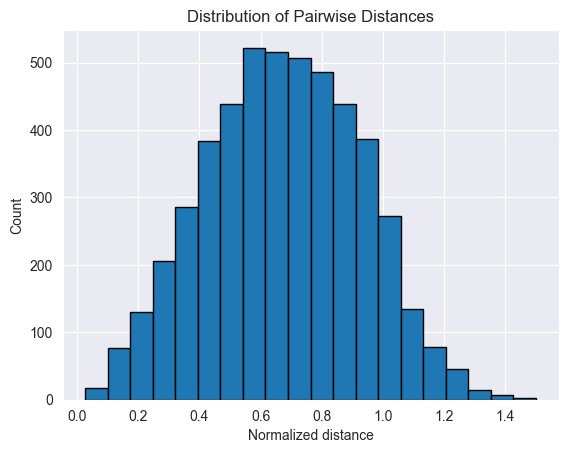

In [134]:
X = df[["alpha_zre","kb_zre","zmean_zre"]].to_numpy()
# Normalize to [0,1]
Xn = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
D = pdist(Xn)

print(f"Min Pairwise Distance: {np.min(D):.3f}")
print(f"Median Pairwise Distance: {np.median(D):.3f}")

plt.figure()
plt.hist(D, bins=20, edgecolor='black')
plt.title("Distribution of Pairwise Distances")
plt.xlabel("Normalized distance")
plt.ylabel("Count")
plt.show()

## Simulation Output
- **`tau`** — The optical depth to reionization; measures how many CMB photons were scattered by free electrons.
- **`xmval_list`** — The average ionized fraction of the universe at different times; shows how reionization progressed.
- **`zval_list`** — The redshift values that correspond to each point in the ionization history.
- **`ksz_map`** — A 2D map of temperature fluctuations caused by the kinematic Sunyaev–Zel’dovich effect.
- **`pk_tt`** —

### Check for Invalid or Empty Output

In [135]:
def sim_order(s):
    import re
    m = re.match(r"sim(\d+)$", s)
    return int(m.group(1)) if m else 10**9

H5 = h5f.filename
bad = []
with h5py.File(H5, "r") as f:
    for s in sorted(f["sims"].keys(), key=sim_order):
        g = f["sims"][s]
        pk = g["pk_tt"][()]
        kz = g["ksz_map"][()]
        if pk.size == 0 or kz.size == 0 or np.any(~np.isfinite(pk)) or np.any(~np.isfinite(kz)):
            bad.append(s)
bad

[]

### kSZ Map Mean/STD Distribution

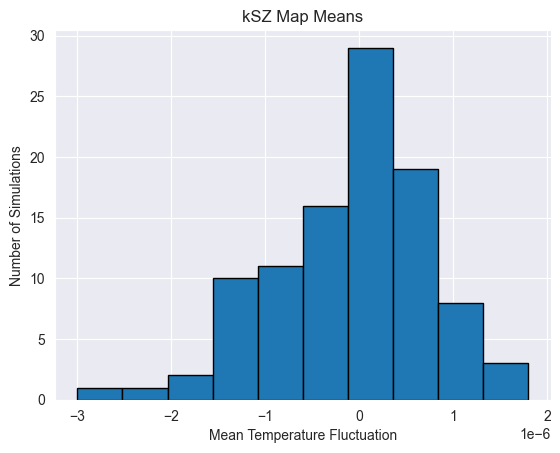

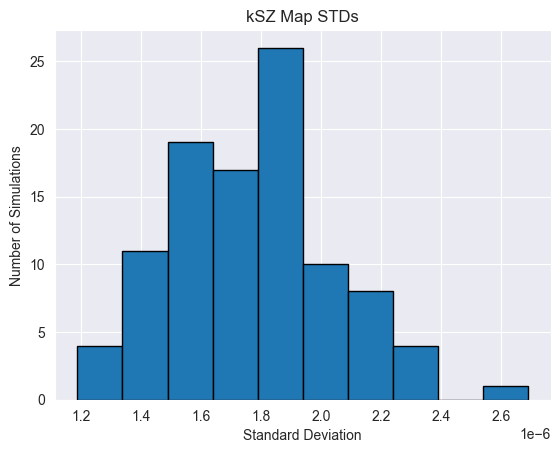

In [136]:
means, stds = [], []
with h5py.File(H5, "r") as f:
    for s in f["sims"].keys():
        m = f["sims"][s]["ksz_map"][()]
        means.append(float(np.mean(m)))
        stds.append(float(np.std(m)))
plt.figure()
plt.hist(means, bins=10, edgecolor='black')
plt.title("kSZ Map Means")
plt.xlabel("Mean Temperature Fluctuation")
plt.ylabel("Number of Simulations")
plt.show()

plt.figure()
plt.hist(stds, bins=10, edgecolor='black')
plt.title("kSZ Map STDs")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Simulations")
plt.show()


### Tau Distribution Histogram

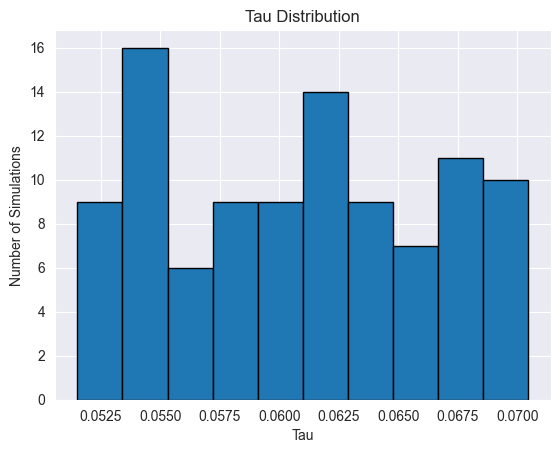

In [137]:
plt.figure()
df["tau"].hist(bins=10, edgecolor="black")
plt.title("Tau Distribution")
plt.xlabel("Tau")
plt.ylabel("Number of Simulations")
plt.show()


### Tau vs Parameter Scatter Plots

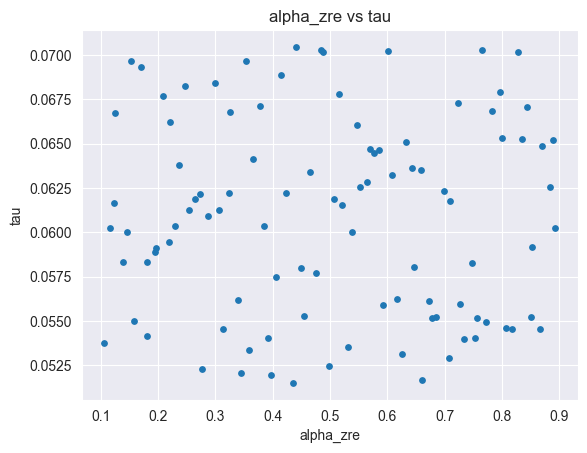

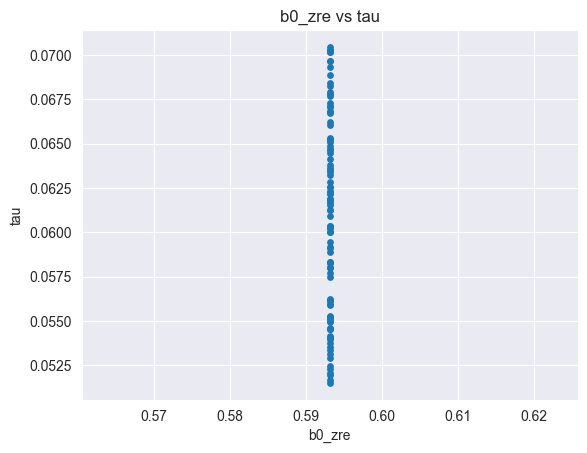

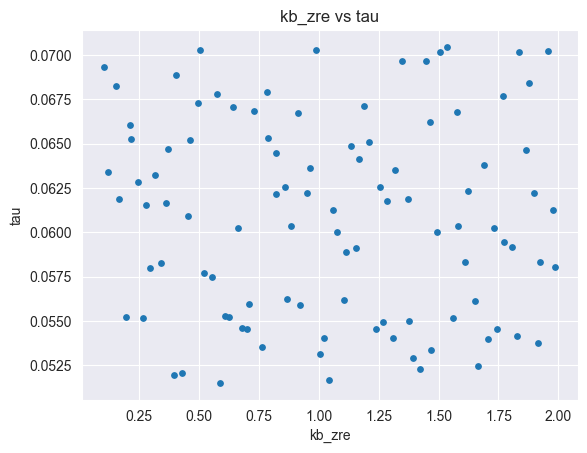

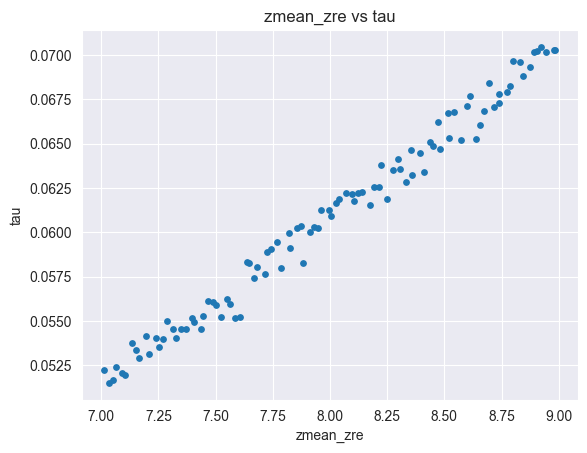

In [138]:
param_cols = ["alpha_zre", "b0_zre", "kb_zre", "zmean_zre"]
for p in param_cols:
    plt.figure()
    plt.scatter(df[p], df["tau"], s=15)
    plt.xlabel(p); plt.ylabel("tau"); plt.title(f"{p} vs tau")
    plt.show()

### Spearman Correlation with Tau
- +1.0 : Perfect increasing monotonic relation
- -1.0 : Perfect decreasing relation
-  0.0 : No Monotonic relation

In [139]:
df[param_cols + ["tau"]].corr(method="spearman")["tau"].sort_values(ascending=False)

tau          1.000000
zmean_zre    0.992895
alpha_zre   -0.010309
kb_zre      -0.056322
b0_zre            NaN
Name: tau, dtype: float64

## Close Files

In [140]:
h5f.close()